# Test the pipeline with the Hungarian Kalman Filter (WKF).

In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get the path of the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.filters.hungarian_kalman_filter import HungarianKalmanFilter

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12


In [2]:
selected = r"\data_2_traces" # "data"
N_traces = 2
batch_size = 5

In [3]:
from scipy.special import factorial

def build_A_matrix(Dt, order):
    """Build state transition matrix A for a constant-jerk-like model of given order."""
    A = np.zeros((order, order), dtype=np.float64)
    for i in range(order):
        for j in range(i, order):
            A[i, j] = Dt**(j - i) / factorial(j - i)
    return A

def build_Q_matrix(Dt, q, order):
    """Build process noise covariance matrix Q for a given order using scaled integrals."""
    Q = np.zeros((order, order), dtype=np.float64)
    for i in range(order):
        for j in range(order):
            power = 2 * order - 1 - i - j
            Q[i, j] = Dt**power / (factorial(order - 1 - i) * factorial(order - 1 - j) * power)
    return q * Q

def build_P_matrix(order):
    """Build initial state covariance matrix P with increasing uncertainty."""
    P = np.zeros((order, order), dtype=np.float64)
    for i in range(order):
        P[i, i] = 10  # Arbitrary scaling: feel free to tune
    P[0, 0] = 1  # Initial position uncertainty
    return P

def evaluate_sources_rmse_gridsearch(
    Dts, qs, sigma_zs, sources_train, sources_eval, selected, N_traces, ut="v1",
    order=3, batch_size=1, write_latex=False, latex_output_dir="output_2_traces/HKF/overlap_0",
    success_threshold=2.0
):
    """
    Perform grid search on training sources, and evaluate best config on separate evaluation sources.

    Parameters:
    - Dts, qs, sigma_zs (list): Grid values for Kalman filter parameters.
    - sources_train (list): Sources used during grid search.
    - sources_eval (list): Sources to evaluate success rate with best parameters.
    - selected (str): Identifier for source name formatting.
    - N_traces (int): Number of traces per image.
    - ut (str): Unique identifier for run.
    - order (int): State model order.
    - batch_size (int): Batch size for evaluation.
    - write_latex (bool): Whether to generate LaTeX tables.
    - latex_output_dir (str): Path to write LaTeX files.
    - success_threshold (float): RMSE threshold for a "success".

    Returns:
    - best_params (dict): Best parameter set.
    - min_RMSE (float): Mean RMSE across training set.
    - min_RMSE_std (float): RMSE std across training set.
    - best_success_rate_train (float): % success (per-curve) on training set.
    - success_rates_eval (list of float): % success (per-curve) per source in sources_eval.
    - results_table (dict): Grid result dictionary with (RMSE, std, success).
    """
    results_table = defaultdict(lambda: defaultdict(dict))
    min_RMSE = np.inf
    best_params = {}
    min_RMSE_std = None
    best_success_rate_train = 0.0

    # -------- GRID SEARCH (on sources_train) --------
    for Dt in tqdm(Dts, desc="Dt"):
        for sigma_z in sigma_zs:
            for q in qs:
                A = build_A_matrix(Dt, order)
                Q = build_Q_matrix(Dt, q, order)
                P = build_P_matrix(order)
                H = np.zeros((1, order), dtype=np.float64)
                H[0, 0] = 1
                R = np.array([[sigma_z**2]], dtype=np.float64)

                all_curve_rmses = []

                for source in sources_train:
                    image_folder_path = os.path.join(source, "signals")
                    GTs_folder_path = os.path.join(source, "ground_truth")

                    output_folder_path = os.path.join(
                        source,
                        f"processed_HKF_dt{Dt:.2f}_q{q:.2f}_sigma_z{sigma_z:.2f}_order{order}_Ntraces{N_traces}_ut{ut}"
                    )
                    os.makedirs(output_folder_path, exist_ok=True)

                    _, _, curve_rmses = evaluate_filter(
                        image_folder_path, GTs_folder_path, output_folder_path,
                        HungarianKalmanFilter(A, H, Q, R),
                        P, batch_size=batch_size, step=1, save=False
                    )

                    all_curve_rmses.extend(curve_rmses)

                RMSE = np.mean(all_curve_rmses)
                RMSE_std = np.std(all_curve_rmses)
                success_rate = np.mean(np.array(all_curve_rmses) <= success_threshold) * 100

                results_table[Dt][q][sigma_z] = (RMSE, RMSE_std, success_rate)

                if RMSE < min_RMSE:
                    min_RMSE = RMSE
                    min_RMSE_std = RMSE_std
                    best_success_rate_train = success_rate
                    best_params = {'Dt': Dt, 'q': q, 'sigma_z': sigma_z}

    # -------- FINAL EVALUATION on sources_eval with best params --------
    success_rates_eval = []
    if best_params:
        Dt, q, sigma_z = best_params['Dt'], best_params['q'], best_params['sigma_z']
        A = build_A_matrix(Dt, order)
        Q = build_Q_matrix(Dt, q, order)
        P = build_P_matrix(order)
        H = np.zeros((1, order), dtype=np.float64)
        H[0, 0] = 1
        R = np.array([[sigma_z**2]], dtype=np.float64)

        for source in sources_eval:
            print(source)
            image_folder_path = os.path.join(source, "signals")
            GTs_folder_path = os.path.join(source, "ground_truth")

            output_folder_path = os.path.join(
                source,
                f"eval_HKF_dt{Dt:.2f}_q{q:.2f}_sigma_z{sigma_z:.2f}_order{order}_Ntraces{N_traces}_ut{ut}"
            )
            os.makedirs(output_folder_path, exist_ok=True)

            _, _, curve_rmses_eval = evaluate_filter(
                image_folder_path, GTs_folder_path, output_folder_path,
                HungarianKalmanFilter(A, H, Q, R),
                P, batch_size=batch_size, step=1
            )

            success_rate_eval = np.mean(np.array(curve_rmses_eval) <= success_threshold) * 100
            success_rates_eval.append(success_rate_eval)

    # -------- LaTeX TABLES (optional) --------
    if write_latex:
        os.makedirs(latex_output_dir, exist_ok=True)
        for Dt in Dts:
            latex = []
            latex.append(r"\begin{table}[H]")
            latex.append(r"\centering")
            latex.append(r"\begin{tabular}{c|" + "c" * len(sigma_zs) + "}")
            latex.append(r"$q \backslash \sigma_z$ & " + " & ".join([f"{sigma:.2f}" for sigma in sigma_zs]) + r"\\")
            latex.append(r"\hline")

            for q in qs:
                row = [f"{q:.2f}"]
                for sigma_z in sigma_zs:
                    entry = results_table[Dt][q].get(sigma_z, None)
                    if entry is not None:
                        rmse, std, success = entry
                        row.append(f"{rmse:.3f} $\\mid$ {std:.3f} $\\mid$ {success:.1f}\\%")
                    else:
                        row.append("-")
                latex.append(" & ".join(row) + r"\\")

            latex.append(r"\end{tabular}")
            latex.append(rf"\caption{{RMSE and success rate (≤ {success_threshold}) for Dt = {Dt:.2f}, ut = {ut}}}")
            latex.append(rf"\label{{tab:rmse_dt_{str(Dt).replace('.', '_')}_ut_{ut}}}")
            latex.append(r"\end{table}")

            file_path = os.path.join(latex_output_dir, f"RMSE_table_dt_{str(Dt).replace('.', '_')}_ut_{ut}.tex")
            with open(file_path, "w") as f:
                f.write("\n".join(latex))

        print(f"LaTeX tables written to {latex_output_dir}")

    return best_params, min_RMSE, min_RMSE_std, best_success_rate_train, success_rates_eval, results_table

In [4]:
sources_eval_sines_2_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-06",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-11",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-17",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-22",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-28",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-33",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-39",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-44",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-50"]

sources_eval_resampled_2_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-00",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-06",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-11",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-17",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-22",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-33",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-39",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-44",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-50"]

sources_eval_resampled_5_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-00",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-05",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-11",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-17",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-22",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-33",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-38",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-44",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-5"]

sources_eval_sines_5_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-00",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-06",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-11",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-17",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-22",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-28",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-33",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-39",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-44",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-50"]

In [5]:
overlaps = np.array([0.00, 0.06, 0.11, 0.17, 0.22, 0.28, 0.33, 0.39, 0.44, 0.50])
success = np.zeros((len(overlaps), 6, 2)) # Shape (overlaps, num_methods, 2) 2 for sines and resampled

labels = [
    r"$3 \mid 0$",
    r"$3 \mid 28$",
    r"$3 \mid \text{ALL}$",
    r"$4 \mid 0$",
    r"$4 \mid 28$",
    r"$4 \mid \text{ALL}$"
]

## Overlap 0, degre 3

In [6]:
Dts = [0.1, 0.5, 0.9]
qs = [0.01, 0.1, 1]
sigma_zs = [0.01, 0.1, 1]

order = 3
N_traces = 2
latex_output_dir = f"output_{N_traces}_traces_order_{order}/HKF/overlap_0"
selected = r"\data_2_traces"
sources_train = [
    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines_long\overlap_0-00"
]
best_params, min_RMSE, min_RMSE_std, best_success_rate_train, success_rates_eval, results_table = evaluate_sources_rmse_gridsearch(
    Dts, qs, sigma_zs,
    sources_train=sources_train,
    sources_eval=sources_eval_sines_2_curves + sources_eval_resampled_2_curves,
    selected=selected,
    N_traces=N_traces,
    ut="grid2",
    order=order,
    batch_size=batch_size,
    write_latex=True, 
    latex_output_dir=latex_output_dir,
    success_threshold=20.0
)

print("Best params:", best_params)
print("Best success rate train:", f"{best_success_rate_train:.1f}%")
print("Success rates eval:", success_rates_eval)

success[:, 0, 0] = success_rates_eval[:len(overlaps)]
success[:, 0, 1] = success_rates_eval[len(overlaps):]

Dt: 100%|██████████| 3/3 [06:12<00:00, 124.28s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overl

## Overlap 28, degre 3

In [7]:
Dts = [0.1, 0.5, 0.9]
qs = [0.01, 0.1, 1]
sigma_zs = [0.01, 0.1, 1]

order = 3
N_traces = 2
latex_output_dir = f"output_{N_traces}_traces_order_{order}/HKF/overlap_28"
selected = r"\data_2_traces"
sources_train = [
    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines_long\overlap_0-28"
]
best_params, min_RMSE, min_RMSE_std, best_success_rate_train, success_rates_eval, results_table = evaluate_sources_rmse_gridsearch(
    Dts, qs, sigma_zs,
    sources_train=sources_train,
    sources_eval=sources_eval_sines_2_curves + sources_eval_resampled_2_curves,
    selected=selected,
    N_traces=N_traces,
    ut="grid2",
    order=order,
    batch_size=batch_size,
    write_latex=True, 
    latex_output_dir=latex_output_dir,
    success_threshold=20.0
)

print("Best params:", best_params)
print("Best success rate train:", f"{best_success_rate_train:.1f}%")
print("Success rates eval:", success_rates_eval)

success[:, 1, 0] = success_rates_eval[:len(overlaps)]
success[:, 1, 1] = success_rates_eval[len(overlaps):]

Dt: 100%|██████████| 3/3 [06:16<00:00, 125.37s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overl

## Overlap ALL, degre 3

In [8]:
# Dts = [0.1, 0.5, 0.9]
# qs = [0.01, 0.1, 1]
# sigma_zs = [0.01, 0.1, 1]

# order = 3
# N_traces = 2
# latex_output_dir = f"output_{N_traces}_traces_order_{order}/HKF/overlap_ALL"
# selected = r"\data_2_traces"
# sources_train = sources_eval_sines_2_curves

# best_params, min_RMSE, min_RMSE_std, best_success_rate_train, success_rates_eval, results_table = evaluate_sources_rmse_gridsearch(
#     Dts, qs, sigma_zs,
#     sources_train=sources_train,
#     sources_eval=sources_eval_sines_2_curves + sources_eval_resampled_2_curves,
#     selected=selected,
#     N_traces=N_traces,
#     ut="grid2",
#     order=order,
#     batch_size=batch_size,
#     write_latex=True, 
#     latex_output_dir=latex_output_dir,
#     success_threshold=20.0
# )

# print("Best params:", best_params)
# print("Best success rate train:", f"{best_success_rate_train:.1f}%")
# print("Success rates eval:", success_rates_eval)

success_rates_eval = [65.0, 50.0, 70.0, 75.0, 65.0, 80.0, 65.0, 45.0, 55.00000000000001, 37.5, 100.0, 100.0, 100.0, 100.0, 90.0, 60.0, 45.0, 17.5, 22.5, 5.0]


success[:, 2, 0] = success_rates_eval[:len(overlaps)]
success[:, 2, 1] = success_rates_eval[len(overlaps):]

LaTeX tables written to output_2_traces_order_3/HKF/overlap_0
Best params: {'Dt': 0.1, 'q': 1, 'sigma_z': 1}
Best success rate train: 60.8%
Success rates eval: [65.0, 50.0, 70.0, 75.0, 65.0, 80.0, 65.0, 45.0, 55.00000000000001, 37.5, 100.0, 100.0, 100.0, 100.0, 90.0, 60.0, 45.0, 17.5, 22.5, 5.0]

## Overlap 0, degre 4

In [9]:
Dts = [0.1, 0.5, 0.9]
qs = [0.01, 0.1, 1]
sigma_zs = [0.01, 0.1, 1]

order = 4
N_traces = 2
latex_output_dir = f"output_{N_traces}_traces_order_{order}/HKF/overlap_0"
selected = r"\data_2_traces"
sources_train = [
    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines_long\overlap_0-00"
]
best_params, min_RMSE, min_RMSE_std, best_success_rate_train, success_rates_eval, results_table = evaluate_sources_rmse_gridsearch(
    Dts, qs, sigma_zs,
    sources_train=sources_train,
    sources_eval=sources_eval_sines_2_curves + sources_eval_resampled_2_curves,
    selected=selected,
    N_traces=N_traces,
    ut="grid2",
    order=order,
    batch_size=batch_size,
    write_latex=True, 
    latex_output_dir=latex_output_dir,
    success_threshold=20.0
)

print("Best params:", best_params)
print("Best success rate train:", f"{best_success_rate_train:.1f}%")
print("Success rates eval:", success_rates_eval)

success[:, 3, 0] = success_rates_eval[:len(overlaps)]
success[:, 3, 1] = success_rates_eval[len(overlaps):]

Dt: 100%|██████████| 3/3 [06:43<00:00, 134.43s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overl

## Overlap 28, degre 4

In [10]:
Dts = [0.1, 0.5, 0.9]
qs = [0.01, 0.1, 1]
sigma_zs = [0.01, 0.1, 1]

order = 4
N_traces = 2
latex_output_dir = f"output_{N_traces}_traces_order_{order}/HKF/overlap_28"
selected = r"\data_2_traces"
sources_train = [
    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines_long\overlap_0-28"
]
best_params, min_RMSE, min_RMSE_std, best_success_rate_train, success_rates_eval, results_table = evaluate_sources_rmse_gridsearch(
    Dts, qs, sigma_zs,
    sources_train=sources_train,
    sources_eval=sources_eval_sines_2_curves + sources_eval_resampled_2_curves,
    selected=selected,
    N_traces=N_traces,
    ut="grid2",
    order=order,
    batch_size=batch_size,
    write_latex=True, 
    latex_output_dir=latex_output_dir,
    success_threshold=20.0
)

print("Best params:", best_params)
print("Best success rate train:", f"{best_success_rate_train:.1f}%")
print("Success rates eval:", success_rates_eval)

success[:, 4, 0] = success_rates_eval[:len(overlaps)]
success[:, 4, 1] = success_rates_eval[len(overlaps):]

Dt: 100%|██████████| 3/3 [05:56<00:00, 118.93s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overl

## Overlap ALL, degre 4

In [ ]:
# Dts = [0.1, 0.5, 0.9]
# qs = [0.01, 0.1, 1]
# sigma_zs = [0.01, 0.1, 1]

# order = 4
# N_traces = 2
# latex_output_dir = f"output_{N_traces}_traces_order_{order}/HKF/overlap_ALL"
# selected = r"\data_2_traces"
# sources_train = sources_eval_sines_2_curves

# best_params, min_RMSE, min_RMSE_std, best_success_rate_train, success_rates_eval, results_table = evaluate_sources_rmse_gridsearch(
#     Dts, qs, sigma_zs,
#     sources_train=sources_train,
#     sources_eval=sources_eval_sines_2_curves + sources_eval_resampled_2_curves,
#     selected=selected,
#     N_traces=N_traces,
#     ut="grid2",
#     order=order,
#     batch_size=batch_size,
#     write_latex=True, 
#     latex_output_dir=latex_output_dir,
#     success_threshold=20.0
# )

# print("Best params:", best_params)
# print("Best success rate train:", f"{best_success_rate_train:.1f}%")
# print("Success rates eval:", success_rates_eval)

success_rates_eval =  [100.0, 90.0, 90.0, 87.5, 80.0, 85.0, 75.0, 67.5, 65.0, 52.5, 100.0, 100.0, 100.0, 100.0, 85.0, 60.0, 45.0, 5.0, 10.0, 2.5]
success[:, 5, 0] = success_rates_eval[:len(overlaps)]
success[:, 5, 1] = success_rates_eval[len(overlaps):]

Dt: 100%|██████████| 3/3 [1:36:08<00:00, 1922.78s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overl

LaTeX tables written to output_2_traces_order_4/HKF/overlap_0
Best params: {'Dt': 0.1, 'q': 1, 'sigma_z': 1}
Best success rate train: 79.2%
Success rates eval: [100.0, 90.0, 90.0, 87.5, 80.0, 85.0, 75.0, 67.5, 65.0, 52.5, 100.0, 100.0, 100.0, 100.0, 85.0, 60.0, 45.0, 5.0, 10.0, 2.5]

## PLOT

In [20]:
success.shape

(10, 6, 2)

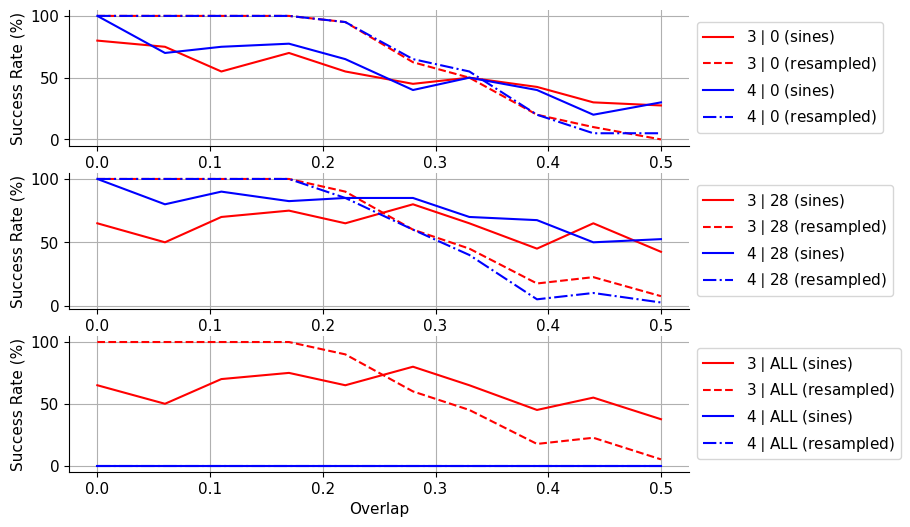

In [12]:
# Dark, bold tones
colors_dark = [
    "#8B0000",  # dark red
    "#004d00",  # deep green
    "#00008B",  # dark blue
    "#4B0082",  # indigo
    "#5A4FCF",  # dark periwinkle
    "#2F4F4F"   # dark slate gray
]

# Shiny, vibrant colors
colors_shiny = [
    "#FF4500",  # shiny orange-red
    "#00FF7F",  # spring green
    "#1E90FF",  # dodger blue
    "#FF69B4",  # hot pink
    "#FFD700",  # gold
    "#FF00FF"   # magenta
]



fig, ax = plt.subplots(3, 1, figsize=(8, 6))

for i in range(success.shape[1]//2):
    idx = i + success.shape[1]//2
    ax[i].plot(overlaps, success[:, i, 0], label=labels[i] + " (sines)", linestyle="-", color='red')
    ax[i].plot(overlaps, success[:, i, 1], label=labels[i] + " (resampled)", linestyle="--", color='red')
    ax[i].plot(overlaps, success[:, idx, 0], label=labels[idx] + " (sines)", linestyle="-", color='blue')
    ax[i].plot(overlaps, success[:, idx, 1], label=labels[idx] + " (resampled)", linestyle="-.", color='blue')

# for i in range(success.shape[1]//2):
#     ax.plot(overlaps, success[:, i, 0], label=labels[i] + " (sines)", linestyle="-", color=colors_dark[i])
#     ax.plot(overlaps, success[:, i, 1], label=labels[i] + " (resampled)", linestyle="--", color=colors_dark[i])
    
# for j in range(success.shape[1]//2):
#     i = j + success.shape[1]//2
#     ax.plot(overlaps, success[:, i, 0], label=labels[i] + " (sines)", linestyle="-", color=colors_shiny[j])
#     ax.plot(overlaps, success[:, i, 1], label=labels[i] + " (resampled)", linestyle="--", color=colors_shiny[j])

for i in range(success.shape[1]//2):
    ax[i].set_ylabel("Success Rate (%)")
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[-1].set_xlabel("Overlap")


fig.savefig("HKF_2_curvess_success_rate_vs_overlap.pdf", dpi=300, bbox_inches='tight', format='pdf')